## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample 
import scipy
import sklearn.model_selection as skl

## Do some early processing of your metadata for easier model training:

In [33]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
2735,00000727_001.png,No Finding,1,727,54,F,PA,2992,2991,0.143,0.143,NaN,/data/images_001/images/00000727_001.png
45047,00011571_002.png,No Finding,2,11571,48,F,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00011571_002.png
26047,00006841_007.png,Atelectasis|Effusion,7,6841,49,M,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00006841_007.png


In [34]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
89992,00022360_001.png,No Finding,1,22360,65,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23408,00006204_005.png,No Finding,5,6204,73,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
107743,00029118_007.png,Atelectasis|Infiltration|Pleural_Thickening|Pn...,7,29118,56,F,PA,2544,3056,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [35]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda x: "P" if x.Pneumonia == 1.0 else "N", axis=1)
all_xray_df.tail()
# Todo

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,P
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N


## Create your training and testing data:

In [36]:
## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
def create_splits(df):
    
    train_df, valid_df = skl.train_test_split(df, test_size = 0.2, stratify = df['pneumonia_class'])
    
    p_inds = train_df[train_df['pneumonia_class']=='P'].index.tolist()
    np_inds = train_df[train_df['pneumonia_class']=='N'].index.tolist()
    
    np_sample = sample(np_inds,len(p_inds))
    # final training data with equal numbers of pn and non-pn cases
    train_data = train_df.loc[p_inds + np_sample]
    
    vp_inds = valid_df[valid_df['pneumonia_class']=='P'].index.tolist()
    vnp_inds = valid_df[valid_df['pneumonia_class']=='N'].index.tolist()
    
    vnp_sample = sample(vnp_inds, 4*len(vp_inds))
    # final validation data with 20% pn cases and 80% non-pn cases
    val_data = valid_df.loc[vp_inds + vnp_sample]
    
    return train_data, val_data, p_inds, vp_inds

In [37]:
train_data, val_data, p_inds, vp_inds = create_splits(all_xray_df)
print(len(p_inds), len(vp_inds))

1145 286


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [38]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)

def my_image_augmentation(df):
    
    
    if df == 'train':
        my_idg = ImageDataGenerator(rescale=1. / 255.0,
                                horizontal_flip = True, 
                                vertical_flip = False, 
                                height_shift_range= 0.1, 
                                width_shift_range=0.1, 
                                rotation_range= 20, 
                                shear_range = 0.1,
                                zoom_range=0.1)
    
    if df == 'valid':
        my_idg = ImageDataGenerator(rescale= 1./255.0)
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    
    return my_idg


def make_train_gen():
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    my_train_idg = my_image_augmentation('train')
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe= train_data, 
                                                 directory= None, 
                                                 x_col = 'path' ,
                                                 y_col = 'pneumonia_class' ,
                                                 class_mode = 'binary',
                                                 target_size = IMG_SIZE , 
                                                 batch_size = 32 )
                                         

    return train_gen


def make_val_gen():
    
    my_val_idg = my_image_augmentation('valid')
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = 128) 
    
    return val_gen

In [39]:
## May want to pull a single large batch of random validation data for testing after each epoch:
train_gen = make_train_gen()
val_gen = make_val_gen()


Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [40]:
valX, valY = val_gen.next()

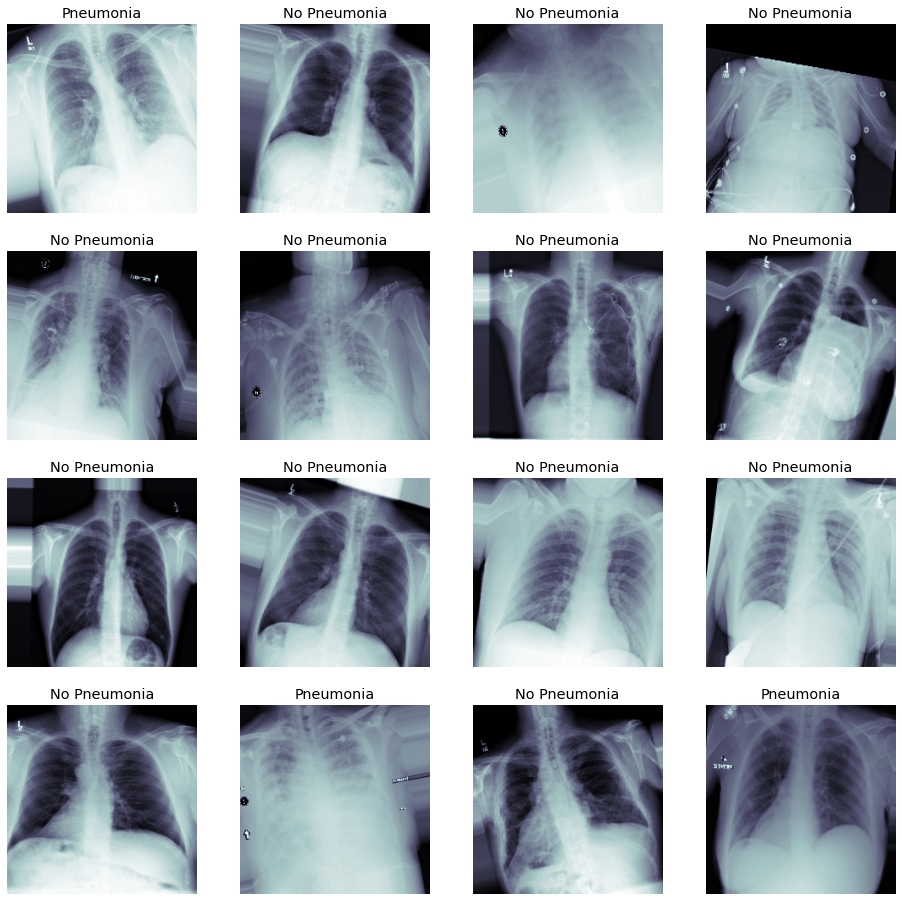

In [41]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [42]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model


In [43]:
load_pretrained_model()

In [44]:
def build_my_model():
    
    vgg_model = load_pretrained_model()
    my_model = Sequential()
    
    # add pre-trained model
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    
#     my_model.add(Dropout(0.3))
#     my_model.add(Dense(256, activation='relu'))
    
    my_model.add(Dense(1, activation='sigmoid'))
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [45]:
optimizer = Adam(lr=6e-6)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
my_model = build_my_model()
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [46]:
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [47]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting


weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor="val_binary_accuracy", 
                             verbose=2, 
                             save_best_only=True, 
                             mode='auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_binary_accuracy', 
                      mode='auto', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [48]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30,
                          callbacks = callbacks_list)

Epoch 1/30
72/72 [==============================] - 61s 850ms/step - loss: 0.7563 - binary_accuracy: 0.4865 - val_loss: 0.6064 - val_binary_accuracy: 0.7344

Epoch 00001: val_binary_accuracy improved from -inf to 0.73438, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
72/72 [==============================] - 57s 785ms/step - loss: 0.7358 - binary_accuracy: 0.5192 - val_loss: 0.6033 - val_binary_accuracy: 0.7344

Epoch 00002: val_binary_accuracy did not improve from 0.73438
Epoch 3/30
72/72 [==============================] - 56s 782ms/step - loss: 0.7211 - binary_accuracy: 0.5179 - val_loss: 0.5884 - val_binary_accuracy: 0.7344

Epoch 00003: val_binary_accuracy did not improve from 0.73438
Epoch 4/30
72/72 [==============================] - 57s 787ms/step - loss: 0.7257 - binary_accuracy: 0.5057 - val_loss: 0.5937 - val_binary_accuracy: 0.7422

Epoch 00004: val_binary_accuracy improved from 0.73438 to 0.74219, saving model to xray_class_my_model.best.hdf5
Epoch 5/30
72/72 [===

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [49]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
# val_gen = make_val_gen()
# valX, valY = val_gen.next()
# new_model = load_pretrained_model()
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

128/128 [==============================] - 1s 10ms/step


In [50]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')    
    plt.show()
    

## what other performance statistics do you want to include here besides AUC? 


# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    
    return precision, recall, thresholds

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

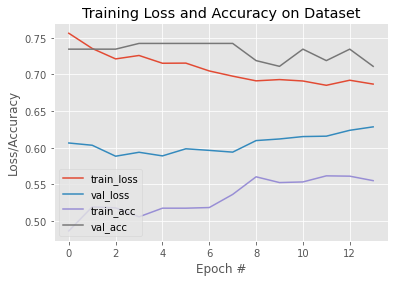

In [51]:
## plot figures
plot_history(history)

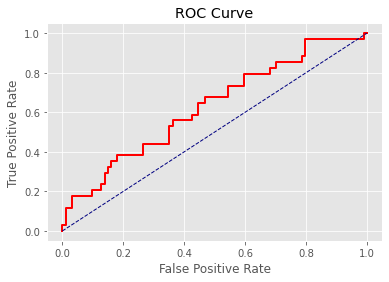

In [52]:
plot_auc(valY, pred_Y)

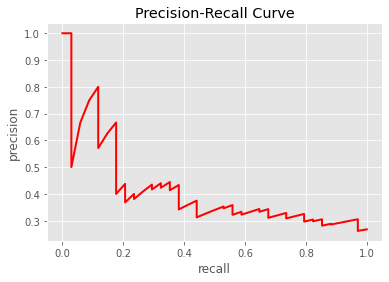

In [53]:
precision, recall, thresholds = plot_precision_recall_curve(valY, pred_Y)

In [54]:
f1 = calc_f1(precision, recall)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [55]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
df = pd.DataFrame({'Precision':precision[:-1], 'Recall':recall[:-1], 'Thresholds':thresholds, 'F1':f1[:-1] })
df.head()

,Precision,Recall,Thresholds,F1
0,0.267717,1.000000,0.301810,0.422360
1,0.261905,0.970588,0.301978,0.412500
2,0.264000,0.970588,0.303829,0.415094
3,0.266129,0.970588,0.306016,0.417722
4,0.268293,0.970588,0.311335,0.420382


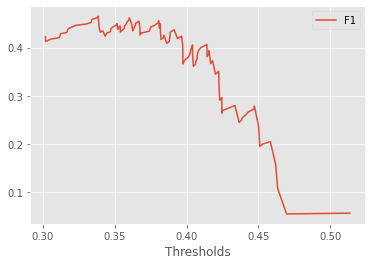

In [56]:
df.plot(x='Thresholds', y='F1', kind='line')

In [57]:
df['F1'].describe()
print('Max F1:', df['F1'].max())
df.iloc[df.F1.idxmax()]

Max F1: 0.46478873239436624


Precision     0.305556
Recall        0.970588
Thresholds    0.338565
F1            0.464789
Name: 19, dtype: float64

In [58]:
threshold = df.iloc[df.F1.idxmax()]['Thresholds']
print('threshold:', threshold)

threshold: 0.33856484293937683


In [59]:
max_precision = df.iloc[df.F1.idxmax()]['Precision']
print('max precision:', max_precision)

max precision: 0.3055555555555556


In [60]:
max_recall = df.iloc[df.F1.idxmax()]['Recall']
print('max recall:', max_recall)

max recall: 0.9705882352941176


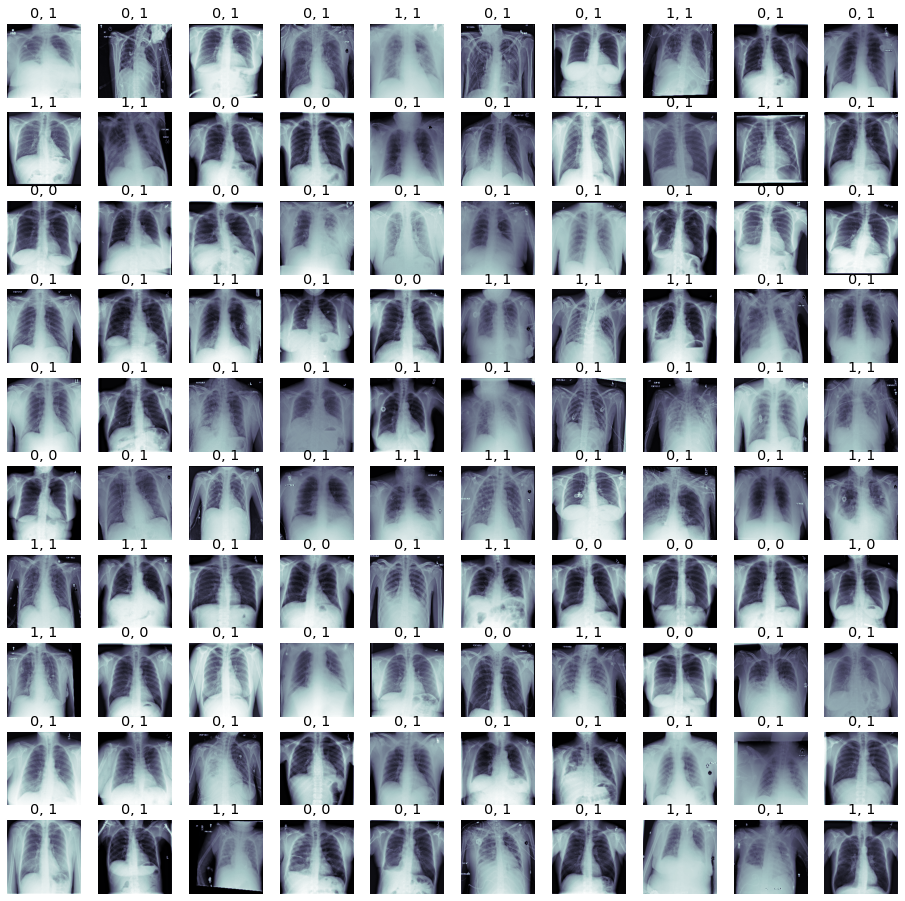

In [61]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [62]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)